## Imports

In [128]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import time
import memory_profiler
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, AveragePooling2D
from tensorflow.keras.models import Model, Sequential

In [126]:
# Завантаження даних
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# Нормалізація даних
# x_train = tf.keras.utils.normalize(x_train, axis=1)
# x_test = tf.keras.utils.normalize(x_test, axis=1)

# Нормалізація
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# reshape
x_train_flat = x_train.reshape((len(x_train), -1))
x_test_flat = x_test.reshape((len(x_test), -1))

x_train_flat.shape

(60000, 784)

## Pipeline

In [102]:
# SVD
svd = TruncatedSVD(n_components=144)

def svd_fit():
    svd.fit(x_train_flat)

start_time = time.time()
svd_fit()
svd_train_time = time.time() - start_time

x_train_flat_cut = svd.transform(x_train_flat)
x_test_flat_cut = svd.transform(x_test_flat)
x_train_flat_cut.shape

(60000, 144)

In [28]:
# AE
latent_dim = 16
inputs = Input(shape=(784,))
encoded = Dense(128, activation='relu')(inputs)
encoded = Dense(latent_dim, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = tf.keras.Model(inputs, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

def ae_fit():
    autoencoder.fit(x_train_flat, x_train_flat_cut, epochs=10)

start_time = time.time()
ae_fit()
AE_train_time = time.time() - start_time

x_train_flat_cut = autoencoder.predict(x_train_flat)
print(x_train_flat_cut.shape)
x_test_flat_cut = autoencoder.predict(x_test_flat)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0319
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0204
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0186
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0171
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0162
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0156
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0152
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0148
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0146
Epoch 10/10
1875/1875 [==============================] - 2s 876us/step
(60000, 784)
313/313 [==============================] - 0s 946us/step


In [23]:
# SVD
svd = TruncatedSVD(n_components=676)

def svd_fit():
    svd.fit(x_train_flat_cut)

start_time = time.time()
svd_fit()
svd_train_time = time.time() - start_time

x_train_transformed = svd.transform(x_train_flat_cut)
print(x_train_transformed.shape)
x_test_transformed = svd.transform(x_test_flat_cut)

(60000, 676)


In [ ]:
x_train_reduced = np.reshape(x_train_transformed, (len(x_train_transformed), 26, 26))
x_test_reduced = np.reshape(x_test_transformed, (len(x_test_transformed), 26, 26))
x_train_reduced.shape

## evaluation on model LeNet-5

In [100]:
# Перетворюємо цілочисельні мітки на одне-гаряче кодування
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=10)

### build and train model on original data

In [101]:
def foo_model1():
    # Додаємо канал кольору
    x_train_mod = tf.expand_dims(x_train, axis=-1)
    x_test_mod = tf.expand_dims(x_test, axis=-1)

    model = Sequential()

    # Перший згортковий блок
    model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(28,28,1), padding='same'))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

    # Другий згортковий блок
    model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

    # Повнозв'язні шари
    model.add(Flatten())
    model.add(Dense(120, activation='tanh'))
    model.add(Dense(84, activation='tanh'))
    model.add(Dense(10, activation='softmax'))

    # Компіляція моделі
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(x_train_mod, y_train_cat, batch_size=32, epochs=10, validation_data=(x_test_mod, y_test_cat))
    
    return model, history, x_test_mod

In [132]:
def make_mlp_model(x_train, y_train):
    mlp_model = MLPClassifier(solver = 'lbfgs')
    mlp_model.fit(x_train, y_train)
    return mlp_model

### build and train model on reduced data

In [111]:
def foo_model2():
    # Додаємо канал кольору
    # x_train_reduced_mod = tf.expand_dims(x_train_reduced, axis=-1)
    # x_test_reduced_mod = tf.expand_dims(x_test_reduced, axis=-1)
    x1 = np.reshape(x_train_flat_cut, (len(x_train_flat_cut), 12, 12))
    x2 = np.reshape(x_test_flat_cut, (len(x_test_flat_cut), 12, 12))
    x_train_reduced_mod = tf.expand_dims(x1, axis=-1)
    x_test_reduced_mod = tf.expand_dims(x2, axis=-1)

    model2 = Sequential()

    # Перший згортковий блок
    model2.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='tanh', input_shape=(12,12,1), padding='same'))
    model2.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

    # Другий згортковий блок
    model2.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
    model2.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))

    # Повнозв'язні шари
    model2.add(Flatten())
    model2.add(Dense(120, activation='tanh'))
    model2.add(Dense(84, activation='tanh'))
    model2.add(Dense(10, activation='softmax'))

    # Компіляція моделі
    model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history2 = model2.fit(x_train_reduced_mod, y_train_cat, batch_size=32, epochs=10, validation_data=(x_test_reduced_mod, y_test_cat))
    
    return model2, history2, x_test_reduced_mod

### Performance evaluation

In [104]:
start_time = time.time()
model, history, x_test_mod = foo_model1()
end_time1 = time.time() - start_time

Epoch 1/10

1875/1875 [==============================] - 7s 3ms/step - loss: 0.2179 - accuracy: 0.9355 - val_loss: 0.1048 - val_accuracy: 0.9663
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0868 - accuracy: 0.9732 - val_loss: 0.0764 - val_accuracy: 0.9754
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0597 - accuracy: 0.9818 - val_loss: 0.0592 - val_accuracy: 0.9816
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0456 - accuracy: 0.9857 - val_loss: 0.0493 - val_accuracy: 0.9841
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0371 - accuracy: 0.9883 - val_loss: 0.0462 - val_accuracy: 0.9858
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0311 - accuracy: 0.9902 - val_loss: 0.0433 - val_accuracy: 0.9869
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0261 - accuracy: 0.9912 - val_loss: 0.0382 - val_accuracy

In [105]:
print(f"Час навчання LENet на оригінальних даних - {end_time1}")

Час навчання LENet на оригінальних даних - 58.78175354003906


In [112]:
start_time = time.time()
model2, history2, x_test_reduced_mod = foo_model2()
end_time2 = time.time() - start_time

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.7010 - accuracy: 0.7746 - val_loss: 0.4245 - val_accuracy: 0.8699
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3900 - accuracy: 0.8813 - val_loss: 0.3575 - val_accuracy: 0.8886
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3275 - accuracy: 0.9004 - val_loss: 0.3084 - val_accuracy: 0.9044
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2893 - accuracy: 0.9111 - val_loss: 0.2697 - val_accuracy: 0.9165
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2616 - accuracy: 0.9199 - val_loss: 0.2536 - val_accuracy: 0.9189
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2404 - accuracy: 0.9262 - val_loss: 0.2434 - val_accuracy: 0.9219
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2223 - accuracy: 0.9313 - val_loss: 0.2286 - val_accuracy:

In [113]:
print(f"Час навчання LENet на редукованих даних - {end_time2}")

Час навчання LENet на редукованих даних - 44.67366290092468


313/313 [==============================] - 0s 1ms/step - loss: 0.2009 - accuracy: 0.9366
Оцінка моделей оригінальні\редуковані дані 0.5370392799377441\0.46200013160705566 секунд
Точність: 0.9854999780654907\0.9366000294685364
Втрати: 0.048165276646614075\0.20090121030807495
313/313 [==============================] - 0s 1ms/step
Класифікаційний звіт для оригінальних даних:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       1.00      0.97      0.98      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.98       892
           6       0.98      0.99      0.99       958
           7       0.98      0.99      0.98      1028
           8       0.97      0.99      0.98       974
           9       1.00      0.96      0.98      1009

    accuracy                 

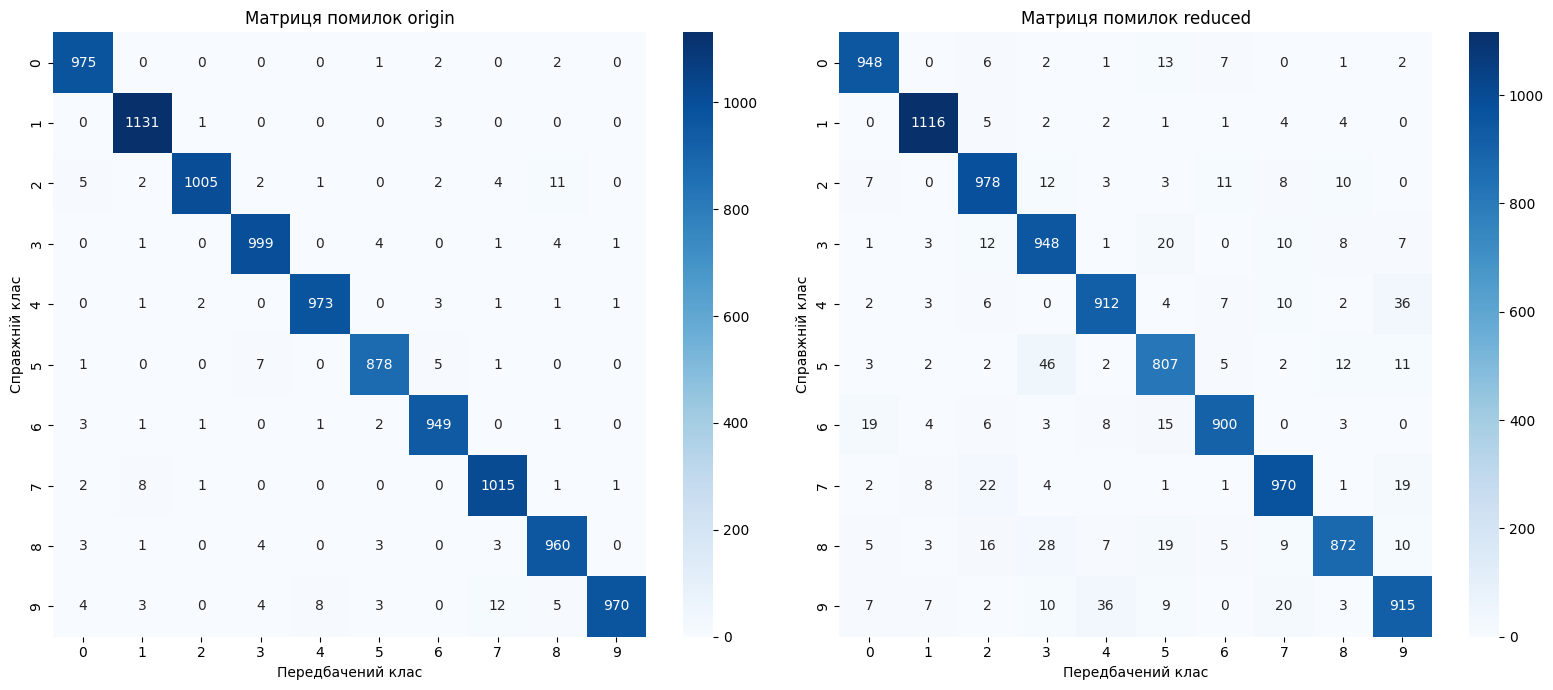

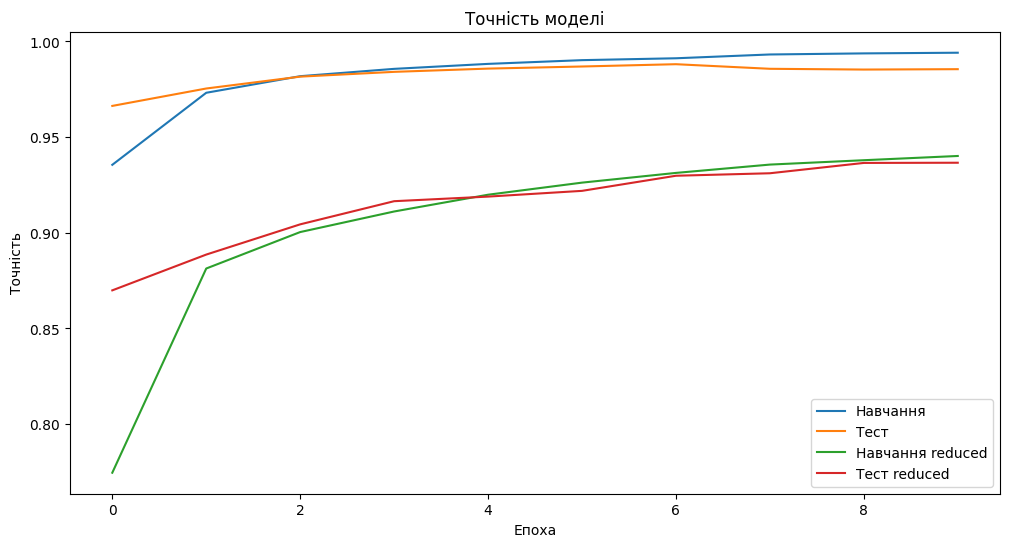

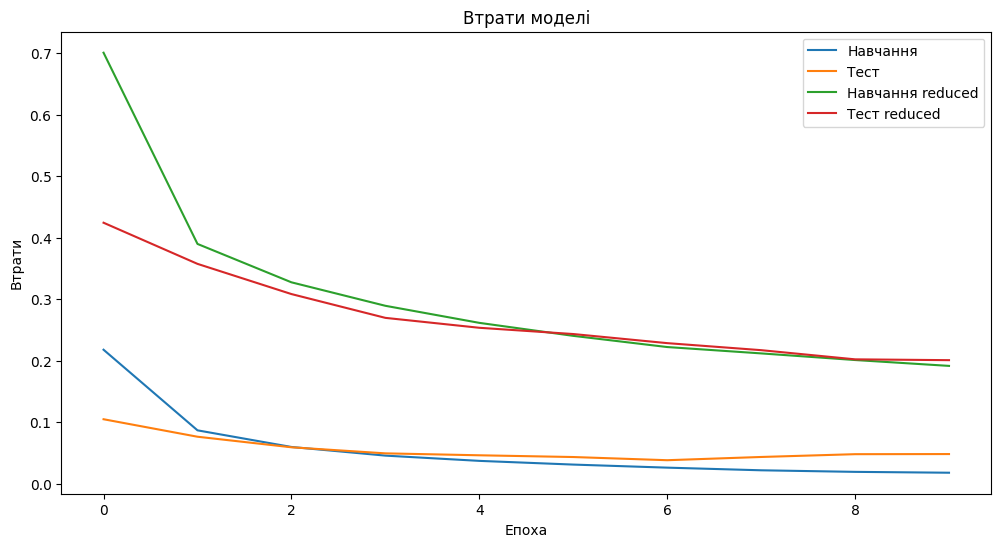

In [119]:
# Оцінка моделі
start_time = time.time()
loss, accuracy = model.evaluate(x_test_mod, y_test_cat)
time1 = time.time() - start_time

start_time = time.time()
loss2, accuracy2 = model2.evaluate(x_test_reduced_mod, y_test_cat)
time2 = time.time() - start_time

print(f"Оцінка моделей оригінальні\редуковані дані {time1}\{time2} секунд")
print(f"Точність: {accuracy}\{accuracy2}")
print(f"Втрати: {loss}\{loss2}")

# Передбачення моделі
y_pred = model.predict(x_test_mod)
y_pred_classes = np.argmax(y_pred, axis=1)

y_pred2 = model2.predict(x_test_reduced_mod)
y_pred_classes2 = np.argmax(y_pred2, axis=1)

# Виведення декількох метрик
print("Класифікаційний звіт для оригінальних даних:")
print(classification_report(y_test, y_pred_classes))
print("Класифікаційний звіт для редукованих даних:")
print(classification_report(y_test, y_pred_classes2))

# confusion_matrix
cm = confusion_matrix(y_test, y_pred_classes)
cm2 = confusion_matrix(y_test, y_pred_classes2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Матриця помилок origin')
ax1.set_xlabel('Передбачений клас')
ax1.set_ylabel('Справжній клас')

sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title('Матриця помилок reduced')
ax2.set_xlabel('Передбачений клас')
ax2.set_ylabel('Справжній клас')
plt.tight_layout()
plt.show()

# Побудова графіка точності
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Точність моделі')
plt.ylabel('Точність')
plt.xlabel('Епоха')
plt.legend(['Навчання', 'Тест', 'Навчання reduced', 'Тест reduced'], loc='best')
plt.show()

# Побудова графіка втрат
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Втрати моделі')
plt.ylabel('Втрати')
plt.xlabel('Епоха')
plt.legend(['Навчання', 'Тест', 'Навчання reduced', 'Тест reduced'], loc='upper right')
plt.show()

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2202 - accuracy: 0.9354 - val_loss: 0.1017 - val_accuracy: 0.9672
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0848 - accuracy: 0.9735 - val_loss: 0.0746 - val_accuracy: 0.9769
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0578 - accuracy: 0.9821 - val_loss: 0.0530 - val_accuracy: 0.9830
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0452 - accuracy: 0.9861 - val_loss: 0.0567 - val_accuracy: 0.9811
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0354 - accuracy: 0.9887 - val_loss: 0.0428 - val_accuracy: 0.9866
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0299 - accuracy: 0.9906 - val_loss: 0.0434 - val_accuracy: 0.9850
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0255 - accuracy: 0.9918 - val_loss: 0.0433 - val_accuracy:

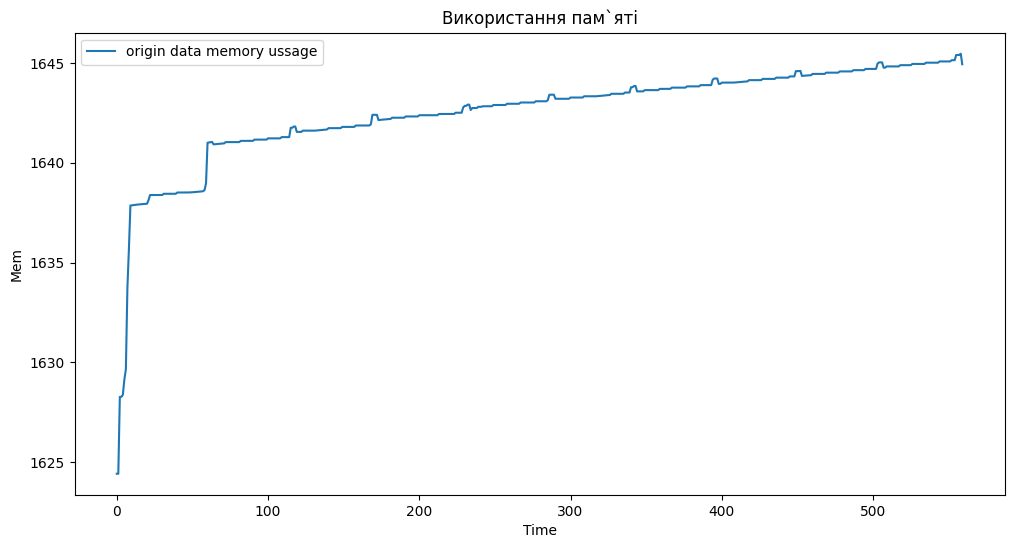

In [120]:
mem_res1 = memory_profiler.memory_usage(foo_model1)
plt.figure(figsize=(12, 6))
plt.plot(mem_res1)
plt.title('Використання пам`яті')
plt.ylabel('Mem')
plt.xlabel('Time')
plt.legend(['origin data memory ussage'])
plt.show()

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.6771 - accuracy: 0.7879 - val_loss: 0.4074 - val_accuracy: 0.8778
Epoch 2/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.3784 - accuracy: 0.8848 - val_loss: 0.3392 - val_accuracy: 0.8966
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3177 - accuracy: 0.9028 - val_loss: 0.2959 - val_accuracy: 0.9098
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2793 - accuracy: 0.9132 - val_loss: 0.2627 - val_accuracy: 0.9197
Epoch 5/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2528 - accuracy: 0.9212 - val_loss: 0.2471 - val_accuracy: 0.9239
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2340 - accuracy: 0.9280 - val_loss: 0.2331 - val_accuracy: 0.9287
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2192 - accuracy: 0.9332 - val_loss: 0.2215 - val_accuracy:

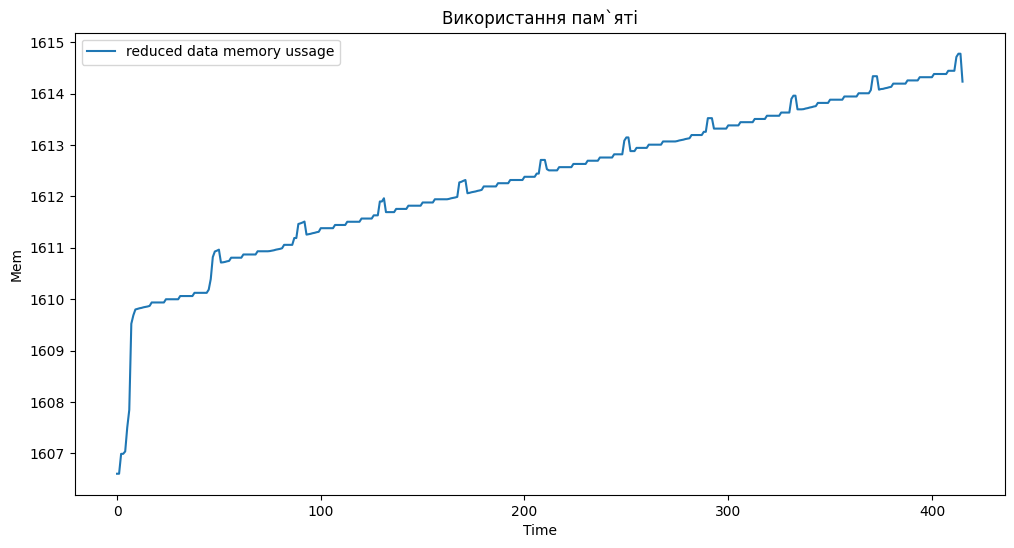

In [118]:
mem_res2 = memory_profiler.memory_usage(foo_model2)
plt.figure(figsize=(12, 6))
plt.plot(mem_res2)
plt.title('Використання пам`яті')
plt.ylabel('Mem')
plt.xlabel('Time')
plt.legend(['reduced data memory ussage'])
plt.show()

In [34]:
print("AE train time:", AE_train_time)
print("SVD train time:", svd_train_time)

AE train time: 35.87047719955444
SVD train time: 10.176604747772217


TODO read:
https://www.kaggle.com/code/jonathankristanto/experimenting-with-pca-on-mnist-dataset

### Performance evaluation 2

In [154]:
def my_score(mlp_model1,x_test):    
    y_pred = mlp_model1.predict(x_test)
    
    print("Класифікаційний звіт для оригінальних даних:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Матриця помилок')
    plt.xlabel('Передбачений клас')
    plt.ylabel('Справжній клас')
    plt.show()

In [136]:
start_time = time.time()
mlp_model = make_mlp_model(x_train_flat, y_train)
print(f"Час навчання mlp на оригінальних даних - {time.time() - start_time}")

Час навчання mlp на оригінальних даних - 32.55025029182434


Класифікаційний звіт для оригінальних даних:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.97      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.97      0.98      0.98       982
           5       0.97      0.97      0.97       892
           6       0.98      0.97      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.97      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



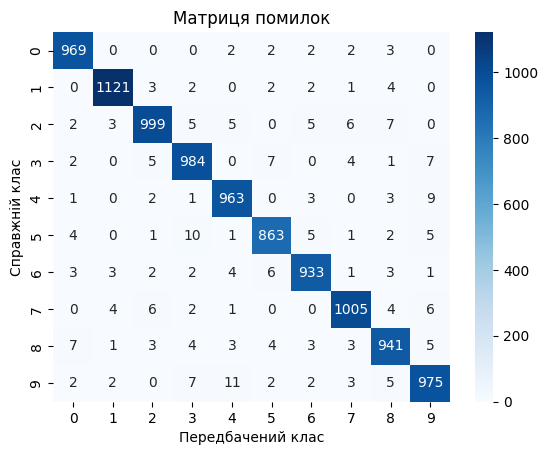

In [155]:
my_score(mlp_model, x_test_flat)

# test

In [97]:
X_recovered = svd.inverse_transform(x_train_flat_cut)
xx = np.reshape(X_recovered, (len(X_recovered), 28, 28))
xx.shape

(60000, 28, 28)

In [98]:
xx2 = np.reshape(x_train_flat_cut, (len(x_train_flat_cut), 12, 12))
xx2.shape

(60000, 12, 12)

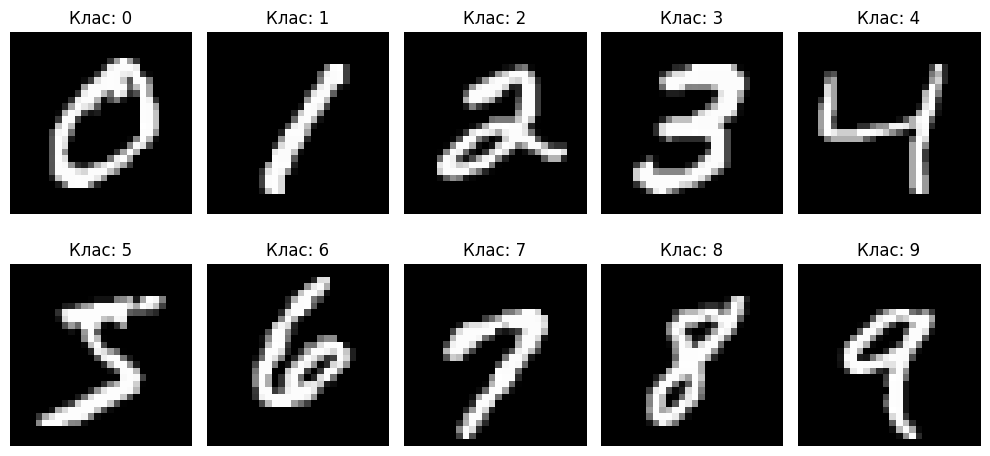

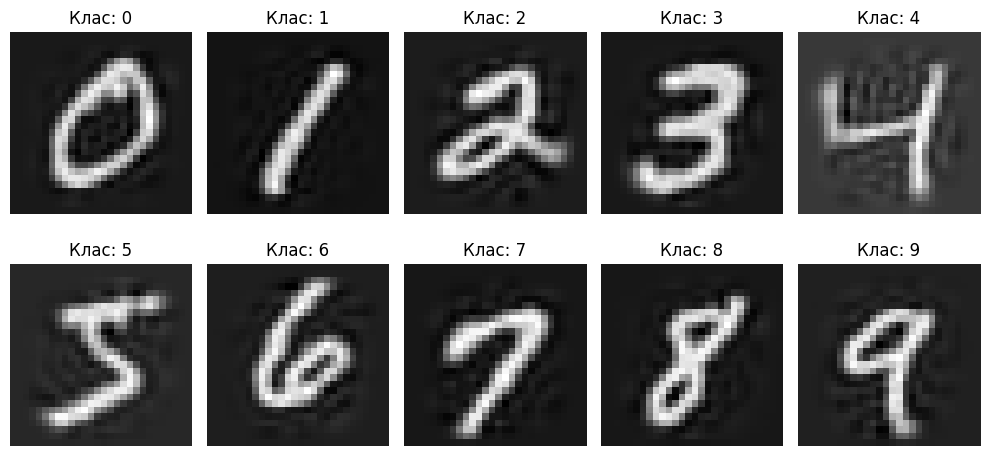

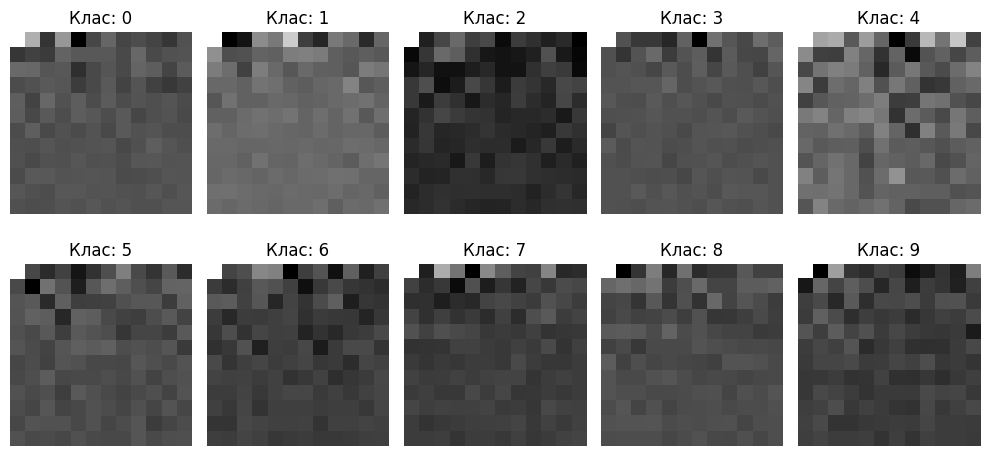

In [99]:
def plot_classes(x,y):
    unique_classes = np.unique(y)
    nrows, ncols = 2, 5
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 5), squeeze=False)

    # Для кожного унікального класу
    for i, digit_class in enumerate(unique_classes):
        row, col = i // ncols, i % ncols
        ax = axes[row][col]
        
        class_indices = np.where(y == digit_class)[0]
        digit_index = class_indices[0]
        digit_data = x[digit_index]
            
        ax.imshow(digit_data, cmap='gray')
        ax.set_title(f"Клас: {digit_class}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_classes(x_train,y_train)
plot_classes(xx,y_train)
plot_classes(xx2,y_train)